In [ ]:
!pip install yfinance
!pip install ta
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29088 sha256=2610e2d95a2e823202f3b29c4e30f80884b21fe7876a46986c5b6036d499ba56
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import json
import requests
import pandas as pd
from datetime import date, timedelta
import collections
from nltk import tokenize
from nltk.tokenize import RegexpTokenizer
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pickle
import time
import pytz
import datetime
import torch
import sklearn.feature_extraction
import sklearn.model_selection
import random
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import ta
from sklearn.ensemble import RandomForestClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from torch.utils.data import DataLoader, TensorDataset

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

In [2]:
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Set the time period 
# Time period of 4 years (1st Jan 2013 - 1st May2023)
specific_date = pd.to_datetime('2013-01-01')
specific_date_time = date(2013, 1, 1)
specific_end_date = pd.to_datetime('2023-04-29')
start_date = date(2012, 11, 1)
end_date = date(2023, 5, 10) 

[*********************100%***********************]  1 of 1 completed


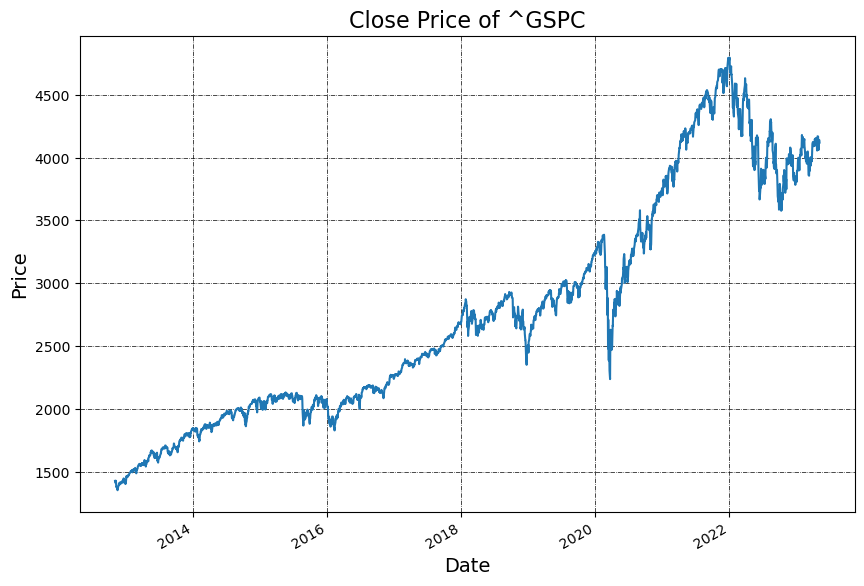

In [4]:
# Get the data for the Stock/Index
ticker = '^GSPC'  
stock_data = yf.download(ticker, start_date, end_date)
stock_data['daily_returns'] =  ((stock_data['Close'] - stock_data['Open']) / stock_data['Open']) * 100

# Plot the adjusted close price
stock_data['Close'].plot(figsize=(10, 7))

plt.title("Close Price of {}".format(ticker), fontsize=16)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

# Show the plot
plt.show()

In [5]:
# Pre-processing the data
# Arrange the dataset to get the Daily Returns
stock_daily_returns = ((stock_data['Close'] - stock_data['Open']) / stock_data['Open']) * 100
stock_returns = pd.DataFrame(stock_daily_returns)
stock_returns.columns = ['Return']
stock_returns = stock_returns.reset_index()

# Days where the stock market is open
tradingDays = pd.DataFrame(stock_returns['Date']).astype(str)
# Arrange index
stock_data["Date"] = stock_data.index
stock_data.reset_index(drop=True, inplace=True)

# get list of trading days so we can use .index()
listOfTradingDays = tradingDays.values.tolist()

In [6]:
# Helper functions to build the dataset
# Function to get 1-day's stock performance
def get1DayReturn(date):
    dayReturn = stock_returns.where(stock_returns['Date'] == date)
    dayReturn = dayReturn.dropna()
    return dayReturn['Return'].iloc[0]

# Function to get tommo's open
def getTommoOpen(date):
    indexOfTommoDay = listOfTradingDays.index([date]) + 1
    if indexOfTommoDay >= len(listOfTradingDays):
        return -1
    date2 = listOfTradingDays[indexOfTommoDay][0]
    return stock_data['Open'].where(stock_data['Date'] == date2).dropna().iloc[0]

def getStockDirection(date, n_day):
    dayOpen = getTommoOpen(date)
    indexOfDay = listOfTradingDays.index([date]) + n_day
    if indexOfDay >= len(listOfTradingDays):
        return -1
    dateClose = listOfTradingDays[indexOfDay][0]
    dayClose = stock_data['Close'].where(stock_data['Date'] == dateClose).dropna().iloc[0]
    if dayClose >= dayOpen:
        return 1
    else: 
        return 0

In [7]:
# Building the Stock prices Dataset
Stock_info = pd.DataFrame({'Today return' : [], 'Tommo_Open' : [], 'Tommo_Direction' : [], '2Day_Direction' : [], '3Day_Direction' : [], '4Day_Direction' : [], '5Day_Direction' : []})
for d in stock_data['Date']:
    Date = d
    date_s = str(d)[0:10]
    new_row = {'Today return': get1DayReturn(d), 'Tommo_Open' : getTommoOpen(date_s) , 'Tommo_Direction': getStockDirection(date_s, 1),'2Day_Direction' : getStockDirection(date_s, 2), '3Day_Direction': getStockDirection(date_s, 3),'4Day_Direction' : getStockDirection(date_s, 4), '5Day_Direction':getStockDirection(date_s, 5)}
    Stock_info = Stock_info.append(new_row, ignore_index=True)

In [8]:
# add this data to the stock_data dataframe
stock_data.drop(columns='daily_returns', inplace=True)
stock_data = pd.merge(stock_data, Stock_info, left_index=True, right_index=True)
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,Date,Today return,Tommo_Open,Tommo_Direction,2Day_Direction,3Day_Direction,4Day_Direction,5Day_Direction
0,1412.199951,1428.349976,1412.199951,1427.589966,1427.589966,3929890000,2012-11-01,1.089790,1427.589966,0.0,0.0,1.0,0.0,0.0
1,1427.589966,1434.270020,1412.910034,1414.199951,1414.199951,3732480000,2012-11-02,-0.937945,1414.020020,1.0,1.0,0.0,0.0,0.0
2,1414.020020,1419.900024,1408.130005,1417.260010,1417.260010,2921040000,2012-11-05,0.229133,1417.260010,1.0,0.0,0.0,0.0,0.0
3,1417.260010,1433.380005,1417.260010,1428.390015,1428.390015,3306970000,2012-11-06,0.785318,1428.270020,0.0,0.0,0.0,0.0,0.0
4,1428.270020,1428.270020,1388.140015,1394.530029,1394.530029,4356490000,2012-11-07,-2.362298,1394.530029,0.0,0.0,0.0,0.0,0.0


In [9]:
# Pre-processing and cleaning
# Keep only trading days after 2021
stock_data = stock_data[stock_data['Date'] > specific_date]
stock_data = stock_data[stock_data['Date'] < specific_end_date]

# reset index
stock_data = stock_data.reset_index()
del stock_data['index']

# delete last row (since we always predict next day)
stock_data = stock_data.iloc[:-1]

In [10]:
stock_data

,Open,High,Low,Close,Adj Close,Volume,Date,Today return,Tommo_Open,Tommo_Direction,2Day_Direction,3Day_Direction,4Day_Direction,5Day_Direction
0,1426.189941,1462.430054,1426.189941,1462.420044,1462.420044,4202600000,2013-01-02,2.540342,1462.420044,0.0,1.0,0.0,0.0,0.0
1,1462.420044,1465.469971,1455.530029,1459.369995,1459.369995,3829730000,2013-01-03,-0.208562,1459.369995,1.0,1.0,0.0,1.0,1.0
2,1459.369995,1467.939941,1458.989990,1466.469971,1466.469971,3424290000,2013-01-04,0.486510,1466.469971,0.0,0.0,0.0,1.0,1.0
3,1466.469971,1466.469971,1456.619995,1461.890015,1461.890015,3304970000,2013-01-07,-0.312312,1461.890015,0.0,0.0,1.0,1.0,1.0
4,1461.890015,1461.890015,1451.640015,1457.150024,1457.150024,3601600000,2013-01-08,-0.324237,1457.150024,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2593,4132.140137,4138.020020,4113.859863,4133.520020,4133.520020,3611750000,2023-04-21,0.033394,4132.069824,1.0,0.0,0.0,1.0,1.0
2594,4132.069824,4142.410156,4117.770020,4137.040039,4137.040039,3290940000,2023-04-24,0.120284,4126.430176,0.0,0.0,1.0,1.0,1.0
2595,4126.430176,4126.430176,4071.379883,4071.629883,4071.629883,3978640000,2023-04-25,-1.328032,4087.780029,0.0,1.0,1.0,1.0,1.0
2596,4087.780029,4089.669922,4049.350098,4055.989990,4055.989990,3837030000,2023-04-26,-0.777685,4075.290039,1.0,1.0,1.0,1.0,1.0


In [11]:
# remove certain features
final_dataset = stock_data.drop(columns=['Date','Tommo_Direction','2Day_Direction', '3Day_Direction', '4Day_Direction', '5Day_Direction'])

In [12]:
print("Number of instances: ", len(final_dataset))

Number of instances:  2598


In [14]:
# Load the preprocessed news data 
News_dataset = pd.read_feather("preprocessed_datasets/Test_2023_dataset.feather") 

# Load Vocab
with open('preprocessed_datasets/vocab_df_200_test.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [15]:
# remove the first day of news since we do not need it (we always predict from tommo open -> close)
News_dataset = News_dataset.drop(index=0)
# arrange index
News_dataset = News_dataset.reset_index()
del News_dataset['index']
News_dataset

,Date,tf_idf
0,2013-01-03,"[0.0, 0.0, 0.07219226694801421, 0.0, 0.0, 0.0,..."
1,2013-01-04,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2013-01-07,"[0.0, 0.0, 0.02502410946465847, 0.175816470019..."
3,2013-01-08,"[0.0, 0.12537474426433934, 0.0, 0.0, 0.0713787..."
4,2013-01-09,"[0.0, 0.0, 0.0, 0.09458333509563867, 0.0, 0.0,..."
...,...,...
2593,2023-04-24,"[0.0, 0.0, 0.0, 0.17779064134043646, 0.0, 0.05..."
2594,2023-04-25,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00907600..."
2595,2023-04-26,"[0.0, 0.0, 0.0, 0.06236315333086975, 0.0, 0.0,..."
2596,2023-04-27,"[0.14575526288464113, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [16]:
News_dataset['News Vector'] = News_dataset['tf_idf']

In [17]:
def Get_Keywords(date, vocab):
    # get news vector for the given date
    vector = np.array(News_dataset.loc[News_dataset['Date'] == date]['News Vector'].iloc[0].copy())
    top_terms = []
    i = 0
    # get top 5 terms from news vector
    while len(top_terms) < 5:
        max_index = vector.argmax()
        if vector[max_index] == 0:
            return top_terms
        term = vocab[max_index]
        if term not in top_terms:
            top_terms.append(term)
        vector[max_index] = -1
        i = i + 1
    print('The top 5 terms are', top_terms)
    return top_terms

Get_Keywords('2023-03-10', vocab)

The top 5 terms are ['valley', 'silicon', 'bank', 'find', 'worri']


['valley', 'silicon', 'bank', 'find', 'worri']

In [18]:
NewsVectors = pd.DataFrame(News_dataset['News Vector'].values.tolist())
NewsVectors.columns = NewsVectors.columns.astype(str)
NewsVectors.head()

,0,1,2,3,4,5,6,7,8,9,...,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086
0,0.0,0.000000,0.072192,0.000000,0.000000,0.0,0.0,0.072192,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.072192,0.000000,0.0,0.000000
1,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.115072,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2,0.0,0.000000,0.025024,0.175816,0.043954,0.0,0.0,0.000000,0.0,0.013951,...,0.043954,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
3,0.0,0.125375,0.000000,0.000000,0.071379,0.0,0.0,0.000000,0.0,0.017383,...,0.000000,0.125375,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4,0.0,0.000000,0.000000,0.094583,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.083066,0.000000,0.047292,0.0,0.083066


In [19]:
# Using news
training_dataset = NewsVectors

In [20]:
# Get the date again
training_dataset['Date'] = pd.to_datetime(News_dataset['Date'])

# Get label also
training_dataset['Label'] = stock_data['Tommo_Direction'] # if we predicting tommo direction
# training_dataset['Label'] = stock_data['2Day_Direction'] # if we predicting next 2 Day Direction
# training_dataset['Label'] = stock_data['3Day_Direction'] # if we predicting next 3 Day Direction
# training_dataset['Label'] = stock_data['4Day_Direction'] # if we predicting next 4 Day Direction
# training_dataset['Label'] = stock_data['5Day_Direction'] # if we predicting 5 Day Direction

In [21]:
training_dataset

,0,1,2,3,4,5,6,7,8,9,...,1079,1080,1081,1082,1083,1084,1085,1086,Date,Label
0,0.000000,0.000000,0.072192,0.000000,0.000000,0.00000,0.0,0.072192,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.072192,0.000000,0.0,0.000000,2013-01-03,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.115072,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2013-01-04,1.0
2,0.000000,0.000000,0.025024,0.175816,0.043954,0.00000,0.0,0.000000,0.0,0.013951,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2013-01-07,0.0
3,0.000000,0.125375,0.000000,0.000000,0.071379,0.00000,0.0,0.000000,0.0,0.017383,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2013-01-08,0.0
4,0.000000,0.000000,0.000000,0.094583,0.000000,0.00000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.083066,0.000000,0.047292,0.0,0.083066,2013-01-09,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2593,0.000000,0.000000,0.000000,0.177791,0.000000,0.05061,0.0,0.028215,0.0,0.028215,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2023-04-24,1.0
2594,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.009076,0.0,0.000000,...,0.0,0.0,0.065461,0.000000,0.000000,0.065461,0.0,0.000000,2023-04-25,0.0
2595,0.000000,0.000000,0.000000,0.062363,0.000000,0.00000,0.0,0.000000,0.0,0.104301,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2023-04-26,0.0
2596,0.145755,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.010104,0.0,0.046262,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2023-04-27,1.0


In [22]:
# Split this training set into train(and validation) and test sets according to date
Train_Test_Sets = []
# Create a list of the train-test split dates
train_test_splits = [
          ('2013-01-01', '2022-12-31', '2023-01-01', '2023-04-01'),]

# Loop over the list of splits and create the corresponding train and test sets
for i, (train_start, train_end, test_start, test_end) in enumerate(train_test_splits):
    train_set = training_dataset[(training_dataset['Date'] >= train_start) & (training_dataset['Date'] <= train_end)].drop(columns=['Date'])
    test_set = training_dataset[(training_dataset['Date'] >= test_start) & (training_dataset['Date'] <= test_end)].drop(columns=['Date'])
    Train_Test_Sets.append((train_set,test_set))

In [23]:
class LSTM_Neural_Network(torch.nn.Module):
    def __init__(self, input_layer, hidden_layer_1, hidden_layer_2, dropout, num_layers):
        super().__init__()

        self.Leakyrelu = torch.nn.LeakyReLU(0.1)
        self.dropout_1 = torch.nn.Dropout(dropout)

        # Add a dense layer 
        self.fc_0 = torch.nn.Linear(input_layer, hidden_layer_1)

        # LSTM layers
        self.lstm_1 = torch.nn.LSTM(hidden_layer_1, hidden_layer_2, num_layers, batch_first=True)

        # Add a dense layer
        self.fc_1 = torch.nn.Linear(hidden_layer_2, 1)

    def forward(self, x):
        # Pass to the fc layer
        x = self.Leakyrelu(self.fc_0(x))
        x = self.dropout_1(x)
        # Pass to the lstm cell
        x , _ = self.lstm_1(x)
        x = x[:, -1, :]
        x = self.fc_1(x)
        return x

In [27]:
# Best found hyperparams
(learning_rate_lstm, epoch_lstm, dropout_lstm, hidden_layer_1_lstm, hidden_layer_2_lstm, num_layer_lstm, batch_size_lstm, look_back_lstm) = (1e-05, 750, 0.3, 750, 128, 1, 128, 15)

In [25]:
# Create heatmap from the confusion matrix
def createConfMatrix(matrix):
    class_names = ['Down','Up']
    tick_marks = [0.5, 1.5]
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="Blues", fmt='g')
    ax.xaxis.set_label_position("top")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.yticks(tick_marks, class_names)
    plt.xticks(tick_marks, class_names)

In [26]:
# function to generate results using best model (LSTM)
def Generate_results(x_Train_set, y_Train_set, X_train, y_train, X_val, y_val, X_test, y_test):
    # Convert current dataset split to tensors
    X_Train = torch.tensor(X_train.values, dtype=torch.float32, device=device)
    y_Train = torch.tensor(y_train.values, dtype=torch.float32, device=device)

    X_Val = torch.tensor(X_val.values, dtype=torch.float32, device=device)
    y_Val = torch.tensor(y_val.values, dtype=torch.float32, device=device)

    X_Test = torch.tensor(X_test.values, dtype=torch.float32, device=device)
    y_Test = torch.tensor(y_test.values, dtype=torch.float32, device=device)

    # Convert current dataset split to tensors
    X_train = torch.tensor(X_train.values, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train.values, dtype=torch.float32, device=device)

    X_val = torch.tensor(X_val.values, dtype=torch.float32, device=device)
    y_val = torch.tensor(y_val.values, dtype=torch.float32, device=device)

    X_test = torch.tensor(X_test.values, dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test.values, dtype=torch.float32, device=device)

    # LSTM
    # define the sequence length (how many days to use as input to the model)
    seq_length = look_back_lstm
    # concat the validation and test sets
    X_val = torch.cat([X_train[-look_back_lstm:], X_val], dim=0)
    y_val = torch.cat([y_train[-look_back_lstm:], y_val], dim=0)

    X_test = torch.cat([X_val[-look_back_lstm:], X_test], dim=0)
    y_test = torch.cat([y_val[-look_back_lstm:], y_test], dim=0)

    # create a sliding window view of the data for sequences of length seq_length
    train_seq = [X_train[i:i+seq_length] for i in range(len(X_train) - seq_length)]
    val_seq = [X_val[i:i+seq_length] for i in range(len(X_val) - seq_length)]
    test_seq = [X_test[i:i+seq_length] for i in range(len(X_test) - seq_length)]

    # convert to PyTorch tensors
    train_seq = torch.stack(train_seq)
    val_seq = torch.stack(val_seq)
    test_seq = torch.stack(test_seq)

    # create PyTorch dataset and data loader
    train_dataset = TensorDataset(train_seq, y_train[seq_length:])
    val_dataset = TensorDataset(val_seq, y_val[seq_length:])
    test_dataset = TensorDataset(test_seq, y_test[seq_length:])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size_lstm, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size_lstm, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size_lstm, shuffle=False)

    # get all train data into inputs and labels tensors
    train_inputs = torch.empty(0, device=device)
    train_labels = torch.empty(0, device=device)
    for inputs, labels in train_dataloader:
        train_inputs = torch.cat([train_inputs, inputs], dim=0)
        train_labels = torch.cat([train_labels, labels], dim=0)

    # get all validation data into inputs and labels tensors
    val_inputs = torch.empty(0, device=device)
    val_labels = torch.empty(0, device=device)
    for inputs, labels in val_dataloader:
        val_inputs = torch.cat([val_inputs, inputs], dim=0)
        val_labels = torch.cat([val_labels, labels], dim=0)

    # get all test data into inputs and labels tensors
    test_inputs = torch.empty(0, device=device)
    test_labels = torch.empty(0, device=device)
    for inputs, labels in test_dataloader:
        test_inputs = torch.cat([test_inputs, inputs], dim=0)
        test_labels = torch.cat([test_labels, labels], dim=0)


    # LSTM
    # Perform Early stopping on the best found parameter option (do this 3 times and keep the best found model)
    best_val_acc = 0.0
    for run in range(0, 3):
        # Instantiate the model
        model = LSTM_Neural_Network(len(X_train[0]), hidden_layer_1_lstm, hidden_layer_2_lstm, dropout_lstm, num_layer_lstm)
        model = model.to(device)


        # Define the optimiser
        optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate_lstm)

        # train on the split
        # train the model
        for step in range(epoch_lstm):
            model.train()
            # train on batches
            for inputs, labels in train_dataloader:
                optimiser.zero_grad()
                outputs = model(inputs)
                loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, labels.unsqueeze(1))
                loss.backward()
                optimiser.step()
            # check accuracy on train set and validation set
            # Test Accuracy on training and validation sets
            model.eval()
            with torch.no_grad():
                # train set
                pred = torch.round(torch.sigmoid(model(train_inputs)))[:, 0].detach().cpu().numpy()
                train_acc = accuracy_score(pred, train_labels.cpu())

                # get validation and test set accuracy (when model learns train set with > 0.5 accuracy)
                if train_acc > 0.5:
                    # validation set
                    predictions = torch.round(torch.sigmoid(model(val_inputs)))[:, 0].detach().cpu().numpy()
                    val_acc = accuracy_score(predictions, val_labels.cpu())
                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        # Save the model
                        torch.save(model.state_dict(), 'lstm_best_model.pth')
            if train_acc > 0.99:
                break
            model.train()
    # Loading the best model
    best_lstm_model = LSTM_Neural_Network(len(X_train[0]), hidden_layer_1_lstm, hidden_layer_2_lstm, dropout_lstm, num_layer_lstm)
    best_lstm_model.load_state_dict(torch.load('lstm_best_model.pth'))

    best_lstm_model = best_lstm_model.to(device)
    best_lstm_model.eval()
    # accuracy of training set
    with torch.no_grad():
        # train set
        pred = torch.round(torch.sigmoid(best_lstm_model(train_inputs)))[:, 0].detach().cpu().numpy()
        test_acc = accuracy_score(pred, train_labels.cpu())
        print("LSTM Training Accuracy:", test_acc)

    # Accuracy on Validation set
    with torch.no_grad():
        # val set
        predictions = torch.round(torch.sigmoid(best_lstm_model(val_inputs)))[:, 0].detach().cpu().numpy()
        val_acc = accuracy_score(predictions, val_labels.cpu())
        print("LSTM Validation Accuracy:", val_acc)

    # Accuracy on Test set
    with torch.no_grad():
        # test set
        pred = torch.round(torch.sigmoid(best_lstm_model(test_inputs)))[:, 0].detach().cpu().numpy()
        test_acc = accuracy_score(pred, test_labels.cpu())
        print("LSTM Test Accuracy:",test_acc)

    # create a confusion matrix
    createConfMatrix(confusion_matrix(test_labels.cpu(), pred))

In [31]:
i = 0
while i < len(Train_Test_Sets):
    print("*** Results for Train:",train_test_splits[i][0],'->',train_test_splits[i][1],'Test:',train_test_splits[i][2],'->',train_test_splits[i][3],"***")
    # Split the train set to have a validation set of 10% of the train data
    X_train, X_val, y_train, y_val = train_test_split(Train_Test_Sets[i][0].drop(columns=['Label']),
                                                      Train_Test_Sets[i][0]['Label'], test_size=0.10 , shuffle=False, random_state=0)
    x_Train_set = Train_Test_Sets[i][0].drop(columns=['Label'])
    y_Train_set = Train_Test_Sets[i][0]['Label']

    # Assign the test set
    X_test = Train_Test_Sets[i][1].drop(columns=['Label'])
    y_test = Train_Test_Sets[i][1]['Label']


    # ML models results
    Generate_results(x_Train_set, y_Train_set, X_train, y_train, X_val, y_val, X_test, y_test)
    print('\n\n')

    i = i + 1

*** Results for Train: 2013-01-01 -> 2022-12-31 Test: 2023-01-01 -> 2023-04-01 ***


KeyboardInterrupt: 

In [32]:
i = 0
while i < len(Train_Test_Sets):
    print("*** Results for Train:",train_test_splits[i][0],'->',train_test_splits[i][1],'Test:',train_test_splits[i][2],'->',train_test_splits[i][3],"***")
    # Split the train set to have a validation set of 10% of the train data
    X_train, X_val, y_train, y_val = train_test_split(Train_Test_Sets[i][0].drop(columns=['Label']),
                                                      Train_Test_Sets[i][0]['Label'], test_size=0.10 , shuffle=False, random_state=0)
    x_Train_set = Train_Test_Sets[i][0].drop(columns=['Label'])
    y_Train_set = Train_Test_Sets[i][0]['Label']

    # Assign the test set
    X_test = Train_Test_Sets[i][1].drop(columns=['Label'])
    y_test = Train_Test_Sets[i][1]['Label']


    # UP and Down Counts for test set
    count_1 = sum(y_test == 1)
    count_0 = sum(y_test == 0)
    print('Test set:')
    print("UP trading days", count_1)
    print("Down trading days", count_0)

    i = i + 1

*** Results for Train: 2013-01-01 -> 2022-12-31 Test: 2023-01-01 -> 2023-04-01 ***
Test set:
UP trading days 34
Down trading days 28
